# Using RNN

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import pydotplus as pyd

import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Input, Flatten, Embedding, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Activation, concatenate

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
#from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
%matplotlib inline
import os
import re
# print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Pre-Processing


In [6]:
#df1 = pd.read_json('/content/drive/MyDrive/sarcasm detection/Datasets/twitter/sarcasm_detection_shared_task_twitter_testing.jsonl',lines=True)
#df = pd.read_json('/content/drive/MyDrive/sarcasm detection/Datasets/twitter/sarcasm_detection_shared_task_twitter_training.jsonl',lines=True)
df1 = pd.read_json('/content/drive/MyDrive/sarcasm/reddit/sarcasm_detection_shared_task_reddit_testing.jsonl',lines=True)
df = pd.read_json('/content/drive/MyDrive/sarcasm/reddit/sarcasm_detection_shared_task_reddit_training.jsonl',lines=True)

df['labels'] = df['label'].apply(lambda x: ['SARCASM', 'NOT_SARCASM'].index(x))
df1['labels'] = df1['label'].apply(lambda x: ['SARCASM', 'NOT_SARCASM'].index(x))
df1.tail()
df3=pd.concat([df1,df])
# df3

- ### Filtering headlines 


In [7]:
# df['response'] = df['response'].apply(lambda x: x.lower())
# df['response'] = df['response'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))


# df1['response'] = df1['response'].apply(lambda x: x.lower())
# df1['response'] = df1['response'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

- ### Defining Max features 
- ### using Tokenizer to vectorize and convert text into Sequences 
 so that the Network can deal with it as input

In [8]:
for idx,row in df.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df3['response'].values)
X_train = tokenizer.texts_to_sequences(df['response'].values)
X_train = pad_sequences(X_train,100)

X_test = tokenizer.texts_to_sequences(df1['response'].values)
X_test = pad_sequences(X_test,100)

vocab_size = len(tokenizer.word_index)
print(vocab_size)

11625


### Splitting data to train & test

In [9]:
Y_train, Y_test = df['labels'],df1['labels']

Y_train, Y_test = pd.get_dummies(Y_train).values, pd.get_dummies(Y_test).values

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4400, 100) (4400, 2)
(1800, 100) (1800, 2)


# Defining the LSTM RNN Model
With softmax activation

In [10]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X_train.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [11]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              mode = 'max', 
                              factor=0.9, 
                              patience=4, 
                              min_lr=0.00001, 
                              verbose=10)

checkpoint = ModelCheckpoint("models/sentiment_model.h5", 
                               monitor="val_accuracy", 
                               mode="max", 
                               save_best_only = True, 
                               verbose=1)

earlystop = EarlyStopping(monitor = 'val_accuracy', 
                            mode="max", 
                            min_delta = 0, 
                            patience = 4,
                            verbose=1)

#### Training the model

In [12]:
batch_size = 128
history=model.fit(X_train, Y_train, epochs = 25, batch_size=batch_size,validation_data=(X_test,Y_test), callbacks=[ earlystop, reduce_lr])

Epoch 1/25
35/35 [==============================] - 71s 1s/step - loss: 0.6910 - accuracy: 0.5231 - val_loss: 0.6862 - val_accuracy: 0.5528
Epoch 2/25
35/35 [==============================] - 44s 1s/step - loss: 0.6504 - accuracy: 0.6400 - val_loss: 0.6703 - val_accuracy: 0.6028
Epoch 3/25
35/35 [==============================] - 44s 1s/step - loss: 0.5696 - accuracy: 0.7150 - val_loss: 0.7303 - val_accuracy: 0.5911
Epoch 4/25
35/35 [==============================] - 44s 1s/step - loss: 0.5141 - accuracy: 0.7573 - val_loss: 0.7501 - val_accuracy: 0.5811
Epoch 5/25
35/35 [==============================] - 46s 1s/step - loss: 0.4662 - accuracy: 0.7813 - val_loss: 0.8207 - val_accuracy: 0.5867
Epoch 6/25
35/35 [==============================] - 45s 1s/step - loss: 0.3976 - accuracy: 0.8215 - val_loss: 0.8848 - val_accuracy: 0.5689

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.
Epoch 00006: early stopping


Let's check the accuracy and score now

In [13]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

15/15 - 3s - loss: 0.8848 - accuracy: 0.5689
score: 0.88
acc: 0.57


### A graph of accuracy & Loss vs Epoch

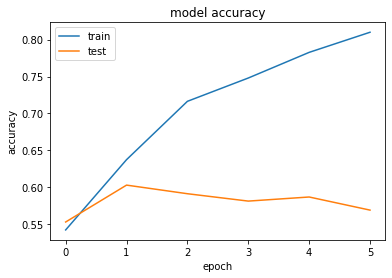

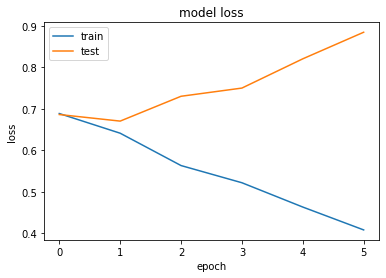

In [14]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
import tensorflow as tf
inp1 = Input(shape=(100,))
x=Embedding(max_fatures, embed_dim,input_length = X_train.shape[1])(inp1)
# x = Embedding(vocab_size, 200, weights=[embedding_matrix])(inp1)
x = tf.keras.layers.Bidirectional(LSTM(256, return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(LSTM(150))(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(64, activation="relu")(x)
x = Dense(2, activation="softmax")(x)    
model21 = Model(inputs=inp1, outputs=x)

print(model21.summary())
model21.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

ValueError: ignored

In [ ]:
batch_size = 64
model21.fit(X_train, Y_train, epochs = 25, batch_size=batch_size,validation_data=(X_test,Y_test), callbacks=[ earlystop, reduce_lr])

# Using CNN

In [ ]:
import pandas as pd
import numpy as np
from numpy import asarray
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import pydotplus as pyd

import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Input, Flatten, Embedding, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Activation, concatenate

In [ ]:
input_data = Input(shape=(100,), name='main_input')
# embedding_layer = Embedding(vocab_size, 200, weights=[embedding_matrix], trainable=False)(input_data)

embedding_layer=Embedding(max_fatures, embed_dim,input_length = X_train.shape[1])(input_data)
conv_1 = Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_layer)
max_1 = MaxPooling1D(pool_size=2)(conv_1)
conv_2 = Conv1D(filters=100, kernel_size=3, activation='relu')(max_1)
max_2 = MaxPooling1D(pool_size=2)(conv_2)
flatten = Flatten()(max_2)
dense = Dense(100, activation='relu', name='fully_connected')(flatten)
out = Dense(2, activation='softmax')(dense)

model_01 = Model(inputs=[input_data], outputs=[out])

print(model_01.summary())

In [ ]:
model_01.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [ ]:
batch_size = 128
history1=model_01.fit(X_train, Y_train, epochs = 25, batch_size=batch_size,validation_data=(X_test,Y_test), callbacks=[ earlystop, reduce_lr])

In [ ]:
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#using CNN-RNN

In [ ]:
input_data1 = Input(shape=(100,), name='main_input')
# embedding_layer = Embedding(vocab_size, 200, weights=[embedding_matrix], trainable=False)(input_data)

embedding_layer11=Embedding(max_fatures, embed_dim,input_length = X_train.shape[1])(input_data1)
conv_11 = Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_layer11)
max_11 = MaxPooling1D(pool_size=2)(conv_11)
conv_21 = Conv1D(filters=100, kernel_size=3, activation='relu')(max_11)
max_21 = MaxPooling1D(pool_size=2)(conv_21)
layer=LSTM(128, activation='sigmoid')(max_21)
flatten1 = Flatten()(layer)
dense1 = Dense(100, activation='relu', name='fully_connected')(flatten1)
out1 = Dense(2, activation='softmax')(dense1)

model_02 = Model(inputs=[input_data1], outputs=[out1])

print(model_02.summary())

In [ ]:
model_02.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [ ]:
batch_size = 128
history2=model_02.fit(X_train, Y_train, epochs = 25, batch_size=batch_size,validation_data=(X_test,Y_test), callbacks=[ earlystop, reduce_lr])

In [ ]:
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()